#### Import Necessary Libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
# load dataset
data = pd.read_csv(r"C:\Users\thars\Downloads\ctr.csv")
print(data.head())

         Date  Clicks  Impressions
0  2022-10-19    2851        58598
1  2022-10-20    2707        57628
2  2022-10-21    2246        50135
3  2022-10-22    1686        40608
4  2022-10-23    1808        41999


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         365 non-null    object
 1   Clicks       365 non-null    int64 
 2   Impressions  365 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.7+ KB


In [4]:
data.shape

(365, 3)

In [5]:
# Let's convert the Date column from string format to date format
data['Date'] = pd.to_datetime(data['Date'],
                                     format='%Y-%m-%d')

In [6]:
data.head()

,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         365 non-null    datetime64[ns]
 1   Clicks       365 non-null    int64         
 2   Impressions  365 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 8.7 KB


In [8]:
# Let's visualize the Clicks and impression over Time
fig = go.Figure()
fig.add_trace(go.Scatter(x = data.index, y = data["Clicks"], mode = "lines", name = "Clicks"))
fig.add_trace(go.Scatter(x = data.index, y = data["Impressions"], mode = "lines", name = "Impressions"))
fig.update_layout(title = "Clicks Vs Impressions")
fig.show()

In [9]:
# Create a relationship to visualize the relationship between Clicks and Impressions
fig = px.scatter(data, x="Clicks", y="Impressions", title="Relationships Between Clicks Impressions",
                 labels={"Clicks":" total clicks", "Impressions":"total impressions"})
#fig.update_layout(xaxis_title = "Clicks", yaxis_title="Impressions")
fig.show()

In [10]:
# Let's Caluclate and Visualize CTR over Time
data["CTR"] = data["Clicks"] / data["Impressions"] * 100
fig = px.line(data,
                 x=data.index, y=data["CTR"],
                   title="Click through Rate (CTR) Over Time")
fig.update_traces(line=dict(color="green"))
fig.show()

In [11]:
# let's have a look at the average CTR day of the week
data["DayofWeek"] = data.Date.dt.day_of_week
data["WeekofMonth"] = (data["Date"].dt.day- 1) // 7 + 1

# EDA Based on DayofWeek
day_of_week_ctr = data.groupby("DayofWeek")["CTR"].mean().reset_index()
day_of_week_ctr["DayofWeek"] = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

#plotting
fig = px.bar(day_of_week_ctr, x="DayofWeek", y="CTR", title="Average CTR By Day of Week")
fig.update_traces(marker_color="skyblue")
fig.show()

In [12]:
day_of_week_ctr

,DayofWeek,CTR
0,Mon,4.174384
1,Tue,4.274768
2,Wed,4.273197
3,Thu,4.252425
4,Fri,3.995702
5,Sat,3.688105
6,Sun,3.976570


In [13]:
# Now let's Compare a CTR column to Weekdays and Weekends
# create a new column DataCategory to categorize weekdays and weekends 
data["DayCategory"] = data["DayofWeek"].apply(lambda x: "Weekends" if x > 5 else "Weekdays")

ctr_by_day_category = data.groupby("DayCategory")["CTR"].mean().reset_index()

#create bar plot
fig = px.bar(ctr_by_day_category, x="DayCategory", y="CTR", title="Comparisons of CTR on Weekdays and Weekends",
             labels={"CTR":"Average CTR"}
             )
fig.update_layout(yaxis_title="Average CTR", width=1200, height=500)
fig.show()

In [14]:
# let's create impressions and clicks on Weekdays and Weekends
# group by DayCategory by and calculate sum of clicks and impressions by weekdays and weekends
grouped_data = data.groupby("DayCategory")[["Clicks", "Impressions"]].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions weekdays and weekends
fig = px.bar(grouped_data, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

# Customize the layout 
fig.update_layout(yaxis_title="Count")
fig.update_xaxes(title_text="Day Category")

#show plot
fig.show()


##### Ads CTR Forecasting

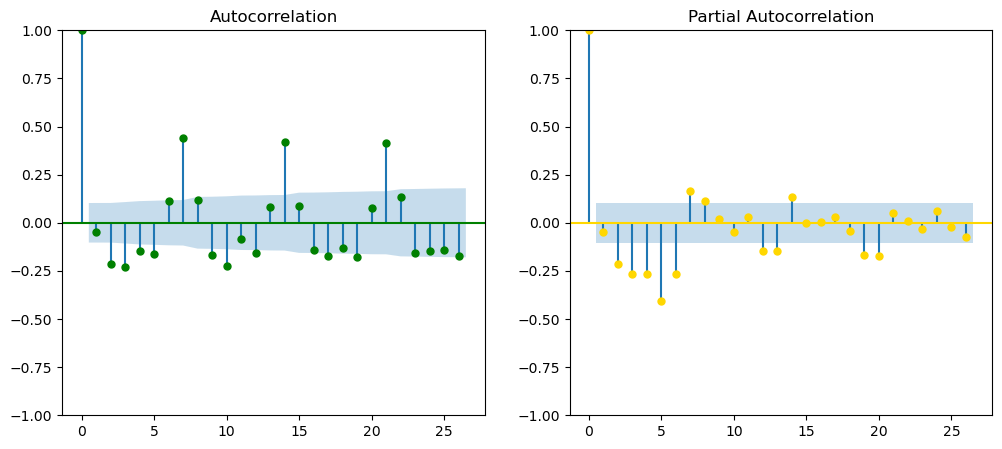

In [25]:


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# resetting index
time_series = data.set_index("Date")["CTR"]

# Differencing 
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differeced Time series
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(differenced_series, ax=axes[0], color="green")
plot_pacf(differenced_series, ax=axes[1], color="gold")

plt.show()

In [28]:
# Now let's train the forecasting model using SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.364
Date:                            Mon, 14 Oct 2024   AIC                            152.728
Time:                                    12:04:01   BIC                            172.046
Sample:                                10-19-2022   HQIC                           160.416
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5265      0.070      7.510      0.000       0.389       0.664
ma.L1         -0.9048      0.036   

In [29]:
# Now here's how to predict the future values 
# predict future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)


2023-10-19    3.852369
2023-10-20    3.889455
2023-10-21    3.820307
2023-10-22    3.727494
2023-10-23    3.710336
                ...   
2024-01-22    3.545449
2024-01-23    3.466522
2024-01-24    3.561068
2024-01-25    3.546583
2024-01-26    3.579982
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


In [59]:
# Now visualize the forecasted trend of CTR
# Create a data frame with original values and predictions
forecast = pd.DataFrame({"Original":time_series, "Predictions":predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast["Predictions"],
                         mode="lines", name="Predictions", line=dict(color="purple")))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast["Original"],
                         mode="lines", name="Original",
                         line=dict(color="red")))
fig.update_layout(title="CTR Forecasting",
                  xaxis_title="Time Periods",
                  yaxis_title="Impressions",
                  legend=dict(x=0.4, y=0.9),
                  showlegend=True)
fig.show()

In [16]:
data.head()

,Date,Clicks,Impressions,CTR,DayofWeek,WeekofMonth,DayCategory
0,2022-10-19,2851,58598,4.865354,2,3,Weekdays
1,2022-10-20,2707,57628,4.697369,3,3,Weekdays
2,2022-10-21,2246,50135,4.479904,4,3,Weekdays
3,2022-10-22,1686,40608,4.151891,5,4,Weekdays
4,2022-10-23,1808,41999,4.304864,6,4,Weekends
